 # CS551 Final Exam: Generative Adversarial Neural Networks



 **Authors:** 
### Final Exam

Fabio Cozzuto	Student id: 002214965

Johan Mogollon	Student id: 002359844

 **Contributions:**

 - **Fabio Cozzuto:** All code, experiments, and analysis

 - **Johan Mogollon:** All code, experiments, and analysis



 This notebook demonstrates:

 1. Padding calculation for DCGAN discriminator

 2. Data‑augmentation pipelines (`basic` vs. `deluxe`)

 3. Visualizing DCGAN samples

 4. Plotting DCGAN training losses

 5. Comparing CycleGAN outputs

# PART 1: Deep Convolutional GAN

 ## Environment Setup & Imports

In [1]:
# Ensure Jupyter can import our GAN modules
import os, sys
sys.path.insert(0, os.path.abspath('.'))
sys.path.append('.') 

# --- Standard Libraries ---
import warnings
warnings.filterwarnings("ignore")


# --- Data Handling ---
import numpy as np
from PIL import Image
import math
np.math = math
 

# --- PyTorch ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

# --- Local Modules ---
from data_loader import get_data_loader, CustomDataSet
from models import DCGenerator, DCDiscriminator, CycleGenerator, conv, deconv, ResnetBlock
from utils import to_var, to_data, create_dir


# --- Visualization ---
import matplotlib.pyplot as plt
import imageio # For saving images


# --- Argument Parsing ---
import argparse
 

# --- Other ---
import glob
 
# Set random seed
SEED = 11
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed(SEED)
 
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Implement Data Augmentation [10 points]

We did the implementation of the augmentations in the code:
![alt text](augmentations.png)

## Implement the Discriminator of the DCGAN [10 points]

 ### 1. Padding Calculation for DCGAN Discriminator

 **Question:** With kernel size \(K=4\) and stride \(S=2\), what padding \(P\) halves the spatial dimensions?



 **Answer:** We want each layer to reduce the spatial dimensions by a factor of 2, without clipping important features. That means we want to control the padding. So, we have the convolution output formula:

```math
O = \left \lfloor \frac{I + 2P - K}{S} \right \rfloor + 1
```
Where:
- \( I \) = input size
- \( O \) = output size
- \( K = 4 \) (kernel size)
- \( S = 2 \) (stride)
- \( P \) = padding

We want to obtain this:
```math
\text output\_size = \frac{input\_size}{2}
```
So we solve with given: 

```math
\left\lfloor \frac{I + 2P - 4}{2} \right\rfloor + 1 = \frac{I}{2}
\Rightarrow 2P = 2 \Rightarrow P = 1
```


In [5]:
# We can do the same calculation with the following code:

input_size = 64  # Example input size, this will vary per layer
kernel_size = 4
stride = 2
padding = 1
output_size = (input_size - kernel_size + 2 * padding) / stride + 1


print(f"Given kernel_size={kernel_size}, stride={stride}, the required padding is: {padding}")
print(f"Example: Input size = {input_size}, Output size = {output_size}")
 

Given kernel_size=4, stride=2, the required padding is: 1
Example: Input size = 64, Output size = 32.0


### 2. DCDiscriminator class in the models.py file

![alt text](DCDiscriminator.png)

## Implement the Generator of the DCGAN [10 points]

### 1. DCGenerator class in the models.py file

![alt text](DCGenerator.png)

 ## Experiments


### 1. Implement the DCGAN Training Loop [10 points]

Discriminator

![alt text](DCGANDisc.png)

Generator

![alt text](DCGANGen.png)

### 2. Train the DCGAN [10 points]

The next code traiin the DCGAN

In [18]:
!python vanilla_gan.py --num_epochs=100

Namespace(image_size=64, conv_dim=32, noise_size=100, num_epochs=100, batch_size=16, num_workers=0, lr=0.0003, beta1=0.5, beta2=0.999, data='cat/grumpifyBprocessed', data_aug='deluxe', ext='*.png', checkpoint_dir='./checkpoints_vanilla', sample_dir='output/./vanilla\\grumpifyBprocessed_deluxe', log_step=10, sample_every=200, checkpoint_every=400)
data/cat/grumpifyBprocessed\*.png
204
                    G                  
---------------------------------------
DCGenerator(
  (deconv1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=

#### Basic Execution

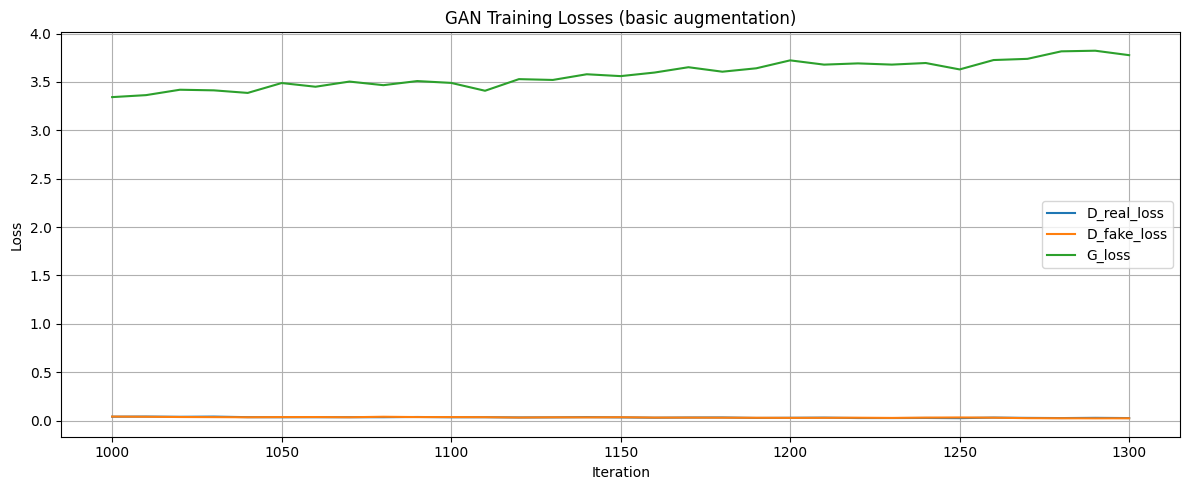

In [ ]:
import re
import matplotlib.pyplot as plt
from subprocess import run, PIPE

# CONFIG
GAN_SCRIPT = "vanilla_gan.py"
DATA_AUG = "basic" 
EPOCHS = "100"

# Run the script and obtain the results
result = run(["python", GAN_SCRIPT, "--num_epochs=" + EPOCHS, "--data_aug=" + DATA_AUG],
             stdout=PIPE, stderr=PIPE, text=True)

output = result.stdout

# We parse the results
iterations = []
d_real = []
d_fake = []
g_loss = []

for line in output.split("\n"):
    if "Iteration" in line and "D_real_loss" in line:
        try:
            iter_num = int(re.search(r"Iteration \[(\d+)", line).group(1))
            d_real_val = float(re.search(r"D_real_loss: ([0-9.]+)", line).group(1))
            d_fake_val = float(re.search(r"D_fake_loss: ([0-9.]+)", line).group(1))
            g_loss_val = float(re.search(r"G_loss: ([0-9.]+)", line).group(1))
            
            iterations.append(iter_num)
            d_real.append(d_real_val)
            d_fake.append(d_fake_val)
            g_loss.append(g_loss_val)
        except:
            pass

# plot
plt.figure(figsize=(12, 5))
plt.plot(iterations, d_real, label='D_real_loss')
plt.plot(iterations, d_fake, label='D_fake_loss')
plt.plot(iterations, g_loss, label='G_loss')
plt.title(f"GAN Training Losses ({DATA_AUG} augmentation)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Deluxe Execution

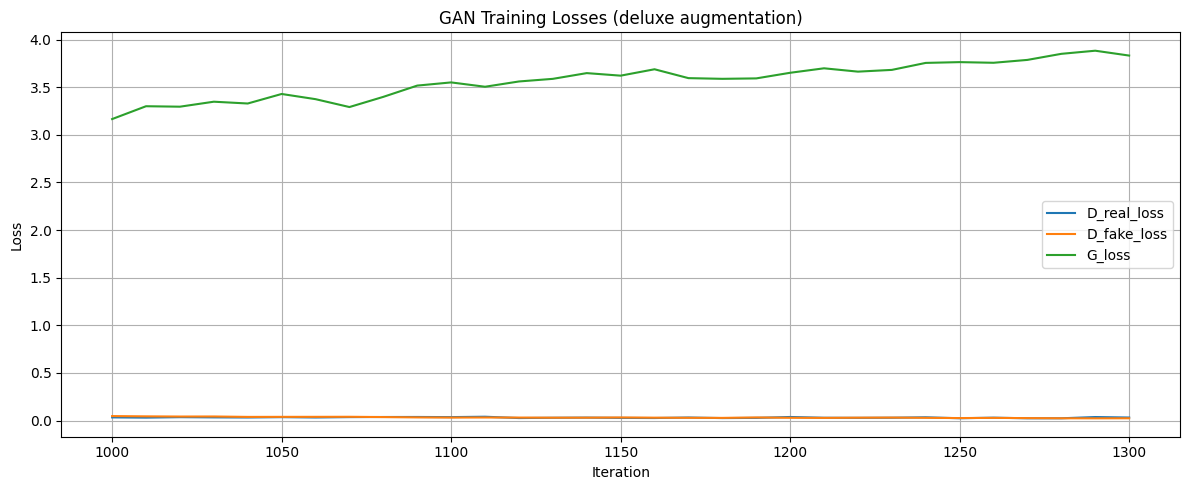

In [20]:
import re
import matplotlib.pyplot as plt
from subprocess import run, PIPE

# CONFIG
GAN_SCRIPT = "vanilla_gan.py"
DATA_AUG = "deluxe"
EPOCHS = "100"

# Run the script and obtain the results
result = run(["python", GAN_SCRIPT, "--num_epochs=" + EPOCHS, "--data_aug=" + DATA_AUG],
             stdout=PIPE, stderr=PIPE, text=True)

output = result.stdout

# We parse the results
iterations = []
d_real = []
d_fake = []
g_loss = []

for line in output.split("\n"):
    if "Iteration" in line and "D_real_loss" in line:
        try:
            iter_num = int(re.search(r"Iteration \[(\d+)", line).group(1))
            d_real_val = float(re.search(r"D_real_loss: ([0-9.]+)", line).group(1))
            d_fake_val = float(re.search(r"D_fake_loss: ([0-9.]+)", line).group(1))
            g_loss_val = float(re.search(r"G_loss: ([0-9.]+)", line).group(1))
            
            iterations.append(iter_num)
            d_real.append(d_real_val)
            d_fake.append(d_fake_val)
            g_loss.append(g_loss_val)
        except:
            pass

# plot
plt.figure(figsize=(12, 5))
plt.plot(iterations, d_real, label='D_real_loss')
plt.plot(iterations, d_fake, label='D_fake_loss')
plt.plot(iterations, g_loss, label='G_loss')
plt.title(f"GAN Training Losses ({DATA_AUG} augmentation)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


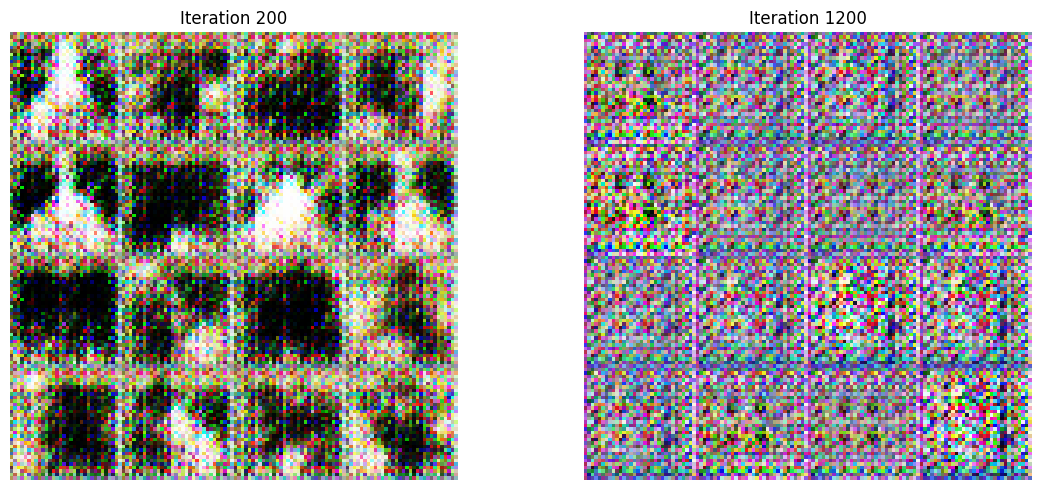

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images from specific iterations
img_early = mpimg.imread("output/vanilla/grumpifyBprocessed_deluxe/sample-000200.png")
img_late = mpimg.imread("output/vanilla/grumpifyBprocessed_deluxe/sample-001200.png")

# Plot the images for comparison
plt.figure(figsize=(12, 5))

# Plot early stage
plt.subplot(1, 2, 1)
plt.imshow(img_early)
plt.title("Iteration 200")
plt.axis('off')

# Plot late stage
plt.subplot(1, 2, 2)
plt.imshow(img_late)
plt.title("Iteration 1200")
plt.axis('off')

plt.tight_layout()
plt.show()


# PART 2: CycleGAN

## Generator [20 points]

![alt text](CycleGANModel.png)

## CycleGAN Training Loop [20 points]

### Discriminator

![alt text](CycleGANDisc.png)

### Generator Y--X-->Y CYCLE

![alt text](CycleGANGen.png)

### Generator X--Y-->X CYCLE  

![alt text](CycleGANGen2.png)

## CycleGAN Experiments [15 points]

In [12]:
!python cycle_gan.py

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 64                                     
                                   disc: dc                                     
                                    gen: cycle                                  
                             g_conv_dim: 32                                     
                             d_conv_dim: 32                                     
                                   norm: instance                               
                              init_type: naive                                  
                            train_iters: 1000                                   
                             batch_size: 16                                     
                                     lr: 0.0003                                 
                            

In [13]:
!python cycle_gan.py --use_cycle_consistency_loss

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 64                                     
                                   disc: dc                                     
                                    gen: cycle                                  
                             g_conv_dim: 32                                     
                             d_conv_dim: 32                                     
                                   norm: instance                               
             use_cycle_consistency_loss: 1                                      
                              init_type: naive                                  
                            train_iters: 1000                                   
                             batch_size: 16                                     
                            